# Protein stability as a log-linear problem


In [1]:
# Modules
import pandas as pd
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt


## Mock dataset
A dataset representing a possible equilibrium denaturation
experiment followed by tryptophan fluorescence.

In [2]:
df = pd.DataFrame({
    "GdmCl": np.array([
        0.25,
        0.50,
        0.75,
        1,
        1.5,
        1.75,
        2,
        2.5,
        2.75,
        3,
        3.5,
        4
    ], dtype=float),
    "Intensity": np.array([
        101,
        97,
        102,
        96,
        88,
        62,
        52,
        48,
        28,
        20,  # 20 or 19
        26,
        23
    ], dtype=float)
})

df.head(12)



,GdmCl,Intensity
0,0.25,101.0
1,0.50,97.0
2,0.75,102.0
3,1.00,96.0
4,1.50,88.0
5,1.75,62.0
6,2.00,52.0
7,2.50,48.0
8,2.75,28.0
9,3.00,20.0


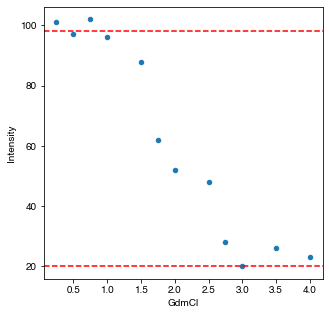

In [3]:
fig = plt.figure(figsize=(5, 5))
ax = fig.subplots(1, 1)
# ax
df.plot.scatter(
    "GdmCl",
    "Intensity",
    ax=ax
)
ax.axhline(20, linestyle="--", color="r")
ax.axhline(98, linestyle="--", color="r")

## Data manipulations
Rescale the data so that it represents the fraction of native (N) protein.
To do so we need to choose appropriate values for the top and bottom baselines,
e.g. 98 and 20.

We determine $K$ as the $\frac{N}{D}$ ratio, as well as $\log(K)$.

In the `logK` column, some `NaN` (not-a-number) values appear when we try to
calculate the logarithm of a negative number, together with a warning 
from python.


In [4]:
def rescale(y, ref_min, ref_max):
    return (y - ref_min) / (ref_max - ref_min)


df['N_ratio'] = df.Intensity.apply(rescale, args=(20, 98))
df['K'] = (1 - df.N_ratio) / df.N_ratio
df['logK'] = df.K.map(np.log10)
df.head()



/usr/local/lib/python3.9/site-packages/pandas/core/base.py:937: RuntimeWarning: invalid value encountered in log10
  new_values = map_f(values, mapper)


,GdmCl,Intensity,N_ratio,K,logK
0,0.25,101.0,1.038462,-0.037037,NaN
1,0.50,97.0,0.987179,0.012987,-1.886491
2,0.75,102.0,1.051282,-0.048780,NaN
3,1.00,96.0,0.974359,0.026316,-1.579784
4,1.50,88.0,0.871795,0.147059,-0.832509


These data transformations are ilustrated in the plots below. 
The dotted vertical lines indicate a possible range where we
may find the **transition region**.

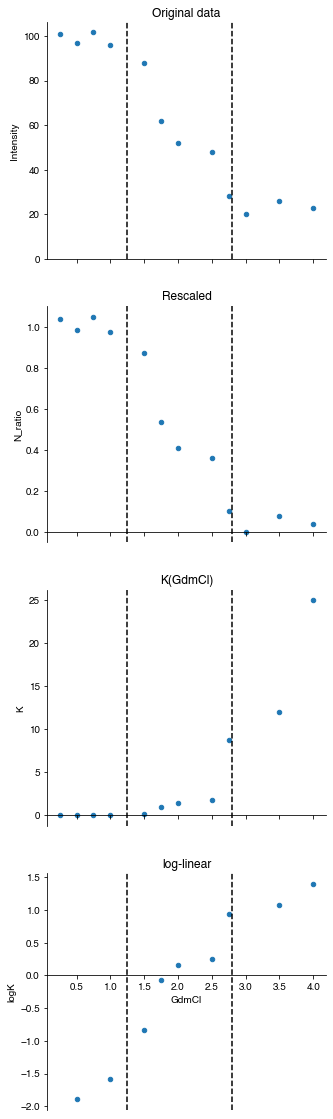

In [5]:
fig = plt.figure(figsize=(5, 20))
ax0, ax1, ax2, ax3 = fig.subplots(4, 1, sharex=True)
# ax0
df.plot.scatter(
    "GdmCl",
    "Intensity",
    ax=ax0
)
ax0.set_ylim(0)
# ax1
df.plot.scatter(
    "GdmCl",
    "N_ratio",
    ax=ax1
)
# ax2
df.plot.scatter(
    "GdmCl",
    "K",
    ax=ax2
)
# ax3
df.plot.scatter(
    "GdmCl",
    "logK",
    ax=ax3
)
titles = ["Original data", "Rescaled", "K(GdmCl)", "log-linear"]
for ax, title in zip([ax0, ax1, ax2, ax3], titles):
    ax.spines.bottom.set_position(("data", 0))
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    ax.set_title(title)
    ax.axvline(1.25, linestyle="--", color="k")
    ax.axvline(2.80, linestyle="--", color="k")



The log-linear approximation is only valid in the transition region. It's not an
easy task to determine this range exactly, so we must make an educated choice.
A reasonable transition interval may be found between 1.25 and 2.80 M GdmCl.


In [6]:
transition = df[df.GdmCl.between(1.25, 2.80)].copy()



In this region, the relationship between $log(K)$ is empirically
accepted to be linear, so we fit the data to a regression line.

In [7]:
res = linregress(transition.GdmCl.values, transition.logK.values)



This is what that model looks like in the transition region. Good, huh?

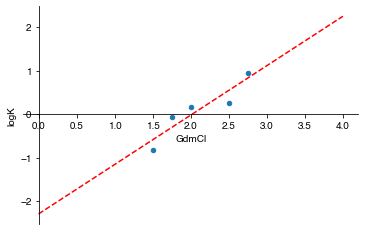

In [8]:
Xpred = np.linspace(0, df.GdmCl.max(), 100)

fig = plt.figure()
ax = fig.subplots(1, 1)
transition.plot.scatter(
    "GdmCl",
    "logK",
    ax=ax
)
ax.plot(
    Xpred,
    res.intercept + res.slope * Xpred,
    linestyle="--",
    color="red",

)
ax.spines.bottom.set_position(("data", 0))
ax.spines.left.set_position(("data", 0))
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)


The equation for the model can be written as follows:

In [9]:
print(
    f"Fitted equation:\n"
    f"logK = {res.intercept.round(2)} + [GdmCl] • {res.slope.round(2)}"
)

Fitted equation:
logK = -2.29 + [GdmCl] • 1.14


and because we are interested in the stability of the protein in the absence of
denaturant, that stability corresponds to the line's intercept:

$$\log(K_{\mathrm{GdmCl}=0}) = -2.29$$

while the midpoint for the transition is found, by definition, at $log(K) = 0$,
so that's:

$$[\mathrm{GdmCl}]_{\frac{1}{2}} = 2.01 M$$